/var/folders/9v/3k54msls5_lcsl4_4qdlbhn40000gn/T/ipykernel_32037/1718165165.py:24: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/var/folders/9v/3k54msls5_lcsl4_4qdlbhn40000gn/T/ipykernel_32037/1718165165.py:25: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(circuit=generator_circuit, input_params=[], weight_params=generator_circuit.parameters, sampler=sampler)


[0] D_loss: 1.3773 | G_loss: 0.6868
[50] D_loss: 0.8491 | G_loss: 0.9977
[100] D_loss: 0.9668 | G_loss: 1.6744
[150] D_loss: 0.9895 | G_loss: 1.8307
[200] D_loss: 0.8870 | G_loss: 2.0451
[250] D_loss: 0.9297 | G_loss: 1.5612
[299] D_loss: 0.7883 | G_loss: 2.1786


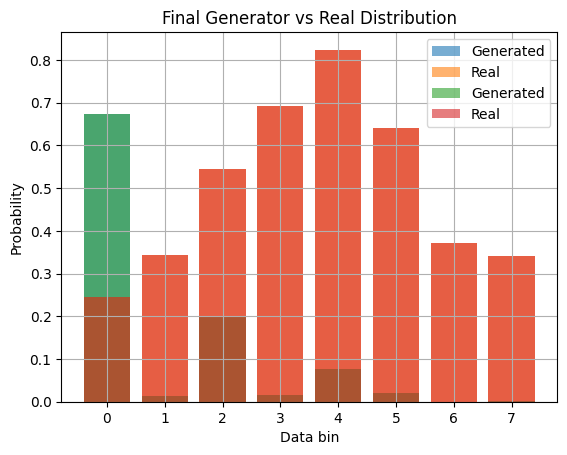

KL divergence: 0.1173


In [11]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

# 1. === DATA ===
# Replace this with your real stock returns
data = np.random.normal(0, 0.5, size=(1000, 1))  # Simulated stock returns
data = np.clip(data, -1.0, 1.0)  # bounds should match generator range

# Normalize data to [0, 2^n - 1] (bitstring representation)
n_qubits = 3
data_bins = 2**n_qubits
hist, bin_edges = np.histogram(data, bins=data_bins, range=(-1.0, 1.0), density=True)
real_data = torch.tensor(hist, dtype=torch.float32)

# 2. === QUANTUM GENERATOR ===
generator_circuit = TwoLocal(n_qubits, rotation_blocks="ry", entanglement_blocks="cz", reps=1, entanglement="circular")
sampler = Sampler()
qnn = SamplerQNN(circuit=generator_circuit, input_params=[], weight_params=generator_circuit.parameters, sampler=sampler)
quantum_generator = TorchConnector(qnn)

# 3. === CLASSICAL DISCRIMINATOR ===
class ClassicalDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.LeakyReLU(0.01),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.01),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = ClassicalDiscriminator(input_dim=2**n_qubits)

# 4. === OPTIMIZERS & LOSS ===
g_optimizer = torch.optim.Adam(quantum_generator.parameters(), lr=0.05)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.01)
bce_loss = nn.BCELoss()

# 5. === TRAINING LOOP ===
epochs = 300
batch_size = 32

for epoch in range(epochs):
    # === TRAIN DISCRIMINATOR ===
    discriminator.zero_grad()
    # Real data (histogram bins as one-hot vectors)
    real_idx = torch.multinomial(real_data, batch_size, replacement=True)
    real_samples = torch.eye(data_bins)[real_idx]
    real_labels = torch.ones((batch_size, 1))

    # Fake data (bitstring samples from quantum generator)
    z = torch.rand(batch_size, 0)  # No input features for generator
    fake_probs = quantum_generator()  # shape: (data_bins,)
    fake_idx = torch.multinomial(fake_probs, batch_size, replacement=True)
    fake_samples = torch.eye(data_bins)[fake_idx]
    fake_labels = torch.zeros((batch_size, 1))

    # Discriminator loss on real and fake
    d_real_loss = bce_loss(discriminator(real_samples), real_labels)
    d_fake_loss = bce_loss(discriminator(fake_samples.detach()), fake_labels)
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    # === TRAIN GENERATOR ===
    quantum_generator.zero_grad()
    fake_preds = discriminator(fake_samples)
    g_loss = bce_loss(fake_preds, torch.ones_like(fake_preds))  # Fool the discriminator
    g_loss.backward()
    g_optimizer.step()

    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"[{epoch}] D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f}")

# 6. === EVALUATE ===
with torch.no_grad():
    probs = quantum_generator().numpy()

plt.bar(range(data_bins), probs, alpha=0.6, label="Generated")
plt.bar(range(data_bins), real_data.numpy(), alpha=0.6, label="Real")
plt.title("Stock Return qGAN Comparison")
plt.xlabel("Data bin")
plt.ylabel("Probability")
plt.legend()
plt.grid(True)

with torch.no_grad():
    final_probs = quantum_generator().numpy()

plt.bar(range(2**n_qubits), final_probs, alpha=0.6, label="Generated")
plt.bar(range(2**n_qubits), real_data.numpy(), alpha=0.6, label="Real")
plt.legend()
plt.title("Final Generator vs Real Distribution")
plt.show()

from scipy.special import rel_entr

kl_div = np.sum(rel_entr(final_probs + 1e-8, real_data.numpy() + 1e-8))
print(f"KL divergence: {kl_div:.4f}")